In [2]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from pathlib import Path
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from MCForecastTools import MCSimulation

In [3]:
load_dotenv()

True

## Data Preparation

In [4]:
Td_data = pd.read_csv("Stock Data - TSE_TD.csv",  index_col="Date")
Bmo_data = pd.read_csv("Stock Data - TSE_BMO (1).csv",index_col="Date")
RY_data = pd.read_csv("Stock Data - TSE_RY (1).csv", index_col="Date")
BNS_data = pd.read_csv("Stock Data - TSE_BNS (2).csv", index_col="Date")
SP500_data = pd.read_csv("Stock Data - S&P 500 (1).csv",index_col="Date")

In [5]:
Stock_concat = pd.concat([Td_data, Bmo_data, RY_data, BNS_data, SP500_data], axis=1, join="inner", keys=["TD", "BMO", "RY", "BNS", "S&P 500"]).dropna().reset_index()

# Sort datetime index in ascending order (past to present)
Stock_concat = Stock_concat.sort_index()

# Display a few rows
Stock_concat.head()

,Date,TD,BMO,RY,BNS,S&P 500
,,Close,Close,Close,Close,Close
0,04/01/2016 16:00:00,53.72,76.66,73.04,55.54,2012.66
1,05/01/2016 16:00:00,53.51,76.62,72.82,56.13,2016.71
2,07/01/2016 16:00:00,51.03,73.52,70.25,54.31,1943.09
3,11/01/2016 16:00:00,51.39,73.61,70.41,54.19,1923.67
4,12/01/2016 16:00:00,52.40,74.18,70.92,54.05,1938.68


In [6]:
Stock_concat1 = pd.concat([Td_data, Bmo_data, RY_data, BNS_data, SP500_data], axis=1, join="inner")
Stock_concat1

,Close,Close,Close,Close,Close
Date,,,,,
04/01/2016 16:00:00,53.72,76.66,73.04,55.54,2012.66
05/01/2016 16:00:00,53.51,76.62,72.82,56.13,2016.71
07/01/2016 16:00:00,51.03,73.52,70.25,54.31,1943.09
11/01/2016 16:00:00,51.39,73.61,70.41,54.19,1923.67
12/01/2016 16:00:00,52.40,74.18,70.92,54.05,1938.68
...,...,...,...,...,...
21/12/2021 16:00:00,94.70,133.14,131.57,87.69,4649.23
22/12/2021 16:00:00,95.41,135.35,132.59,88.67,4696.56
23/12/2021 16:00:00,96.21,135.58,133.64,89.31,4725.79


In [7]:
Stock_concat1.columns= ['TD', 'BMO', 'RY', 'BNS', 'SP500']
Stock_concat1

,TD,BMO,RY,BNS,SP500
Date,,,,,
04/01/2016 16:00:00,53.72,76.66,73.04,55.54,2012.66
05/01/2016 16:00:00,53.51,76.62,72.82,56.13,2016.71
07/01/2016 16:00:00,51.03,73.52,70.25,54.31,1943.09
11/01/2016 16:00:00,51.39,73.61,70.41,54.19,1923.67
12/01/2016 16:00:00,52.40,74.18,70.92,54.05,1938.68
...,...,...,...,...,...
21/12/2021 16:00:00,94.70,133.14,131.57,87.69,4649.23
22/12/2021 16:00:00,95.41,135.35,132.59,88.67,4696.56
23/12/2021 16:00:00,96.21,135.58,133.64,89.31,4725.79


In [8]:
Stock_concat1.describe()

,TD,BMO,RY,BNS,SP500
count,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000
mean,70.401985,97.068022,99.543247,72.003015,2946.422306
std,9.777426,15.579969,14.196212,8.477017,714.147193
min,49.020000,56.240000,65.000000,46.720000,1829.080000
25%,63.210000,86.272500,92.972500,68.262500,2432.480000
50%,72.360000,97.720000,99.645000,74.470000,2797.915000
75%,75.917500,102.417500,105.197500,78.110000,3274.375000
max,97.510000,140.270000,134.790000,91.260000,4793.060000


In [9]:
Stock_concat1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1466 entries, 04/01/2016 16:00:00 to 30/12/2021 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TD      1466 non-null   float64
 1   BMO     1466 non-null   float64
 2   RY      1466 non-null   float64
 3   BNS     1466 non-null   float64
 4   SP500   1466 non-null   float64
dtypes: float64(5)
memory usage: 68.7+ KB


## Evaluate the Riskiness of Stocks

In [10]:
volatility = Stock_concat1.std() * np.sqrt(252)

In [11]:
volatility = volatility.sort_values()
volatility

BNS        134.568478
TD         155.211827
RY         225.357877
BMO        247.324342
SP500    11336.735237
dtype: float64

## Daily returns of the stock

In [12]:
daily_returns = Stock_concat1.pct_change().dropna()
daily_returns

,TD,BMO,RY,BNS,SP500
Date,,,,,
05/01/2016 16:00:00,-0.003909,-0.000522,-0.003012,0.010623,0.002012
07/01/2016 16:00:00,-0.046346,-0.040459,-0.035293,-0.032425,-0.036505
11/01/2016 16:00:00,0.007055,0.001224,0.002278,-0.002210,-0.009994
12/01/2016 16:00:00,0.019654,0.007744,0.007243,-0.002584,0.007803
13/01/2016 16:00:00,-0.017176,-0.029388,-0.024958,-0.019426,-0.024965
...,...,...,...,...,...
21/12/2021 16:00:00,0.007661,0.012164,0.012155,0.009904,0.017778
22/12/2021 16:00:00,0.007497,0.016599,0.007753,0.011176,0.010180
23/12/2021 16:00:00,0.008385,0.001699,0.007919,0.007218,0.006224


In [13]:
Stock_concat1.isnull().mean() * 100

TD       0.0
BMO      0.0
RY       0.0
BNS      0.0
SP500    0.0
dtype: float64

In [14]:
Stock_concat1.isnull().sum()

TD       0
BMO      0
RY       0
BNS      0
SP500    0
dtype: int64

In [15]:
correlation = daily_returns.corr()
correlation

,TD,BMO,RY,BNS,SP500
TD,1.000000,0.840366,0.850373,0.848832,0.687715
BMO,0.840366,1.000000,0.825647,0.837803,0.681616
RY,0.850373,0.825647,1.000000,0.832870,0.714775
BNS,0.848832,0.837803,0.832870,1.000000,0.658362
SP500,0.687715,0.681616,0.714775,0.658362,1.000000


## Plot Correlation

<AxesSubplot:>

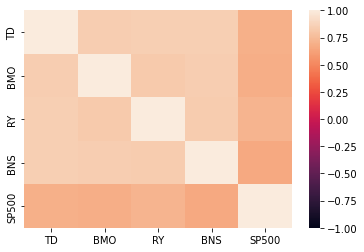

In [17]:
# Create a heatmap from the correlation values and adjust the scale
sns.heatmap(correlation, vmin=-1, vmax=1) 

## Calculate 20-Day Simple Moving Average(SMA20)

In [18]:
sma20 = Stock_concat1.rolling(window=20).mean()
sma20.dropna()

,TD,BMO,RY,BNS,SP500
Date,,,,,
03/02/2016 16:00:00,51.5275,73.3440,69.5400,54.3715,1914.8005
04/02/2016 16:00:00,51.4730,73.2365,69.4375,54.4375,1909.9400
05/02/2016 16:00:00,51.4175,73.1220,69.3535,54.4710,1903.1070
08/02/2016 16:00:00,51.4415,73.1225,69.3055,54.5395,1898.6245
09/02/2016 16:00:00,51.3860,73.0185,69.1670,54.5385,1895.0515
...,...,...,...,...,...
21/12/2021 16:00:00,94.5380,136.8745,129.7160,84.8210,4640.2255
22/12/2021 16:00:00,94.6605,136.7115,129.7640,85.1385,4640.9065
23/12/2021 16:00:00,94.7100,136.4980,129.8625,85.4340,4642.6610


## Calculate 50-Day Simple Moving Average (SMA50)

In [19]:
sma50 = Stock_concat1.rolling(window=50).mean()
sma50.dropna()

,TD,BMO,RY,BNS,SP500
Date,,,,,
17/03/2016 16:00:00,52.3528,74.3554,70.2418,56.2274,1933.4610
18/03/2016 16:00:00,52.3860,74.3944,70.2854,56.3880,1934.1994
21/03/2016 16:00:00,52.4294,74.4428,70.3354,56.5386,1934.8972
22/03/2016 16:00:00,52.5158,74.5456,70.4262,56.7204,1937.0314
23/03/2016 16:00:00,52.5988,74.6470,70.5168,56.9020,1939.2922
...,...,...,...,...,...
21/12/2021 16:00:00,91.8448,136.5010,130.7542,82.9794,4609.4954
22/12/2021 16:00:00,92.0272,136.5940,130.8378,83.1854,4615.5998
23/12/2021 16:00:00,92.2376,136.7126,130.9446,83.4010,4623.1026


## Calculate 100-Day Simple Moving Average(SMA100)

In [20]:
sma100 = Stock_concat1.rolling(window=100).mean()
sma100.dropna()

,TD,BMO,RY,BNS,SP500
Date,,,,,
01/06/2016 16:00:00,54.1268,77.5936,73.4706,59.8595,2000.8136
02/06/2016 16:00:00,54.1654,77.6536,73.5364,59.9586,2001.7396
03/06/2016 16:00:00,54.2028,77.7161,73.6008,60.0520,2002.5638
06/06/2016 16:00:00,54.2661,77.8144,73.6916,60.1675,2004.2270
07/06/2016 16:00:00,54.3298,77.9161,73.7870,60.2963,2006.1116
...,...,...,...,...,...
21/12/2021 16:00:00,87.9343,132.0145,129.8541,80.8873,4524.1814
22/12/2021 16:00:00,88.0559,132.1129,129.9136,80.9920,4527.1406
23/12/2021 16:00:00,88.1810,132.2073,129.9800,81.0986,4530.2070


## Overlay Daily Closing Price of SHOP and SMAs

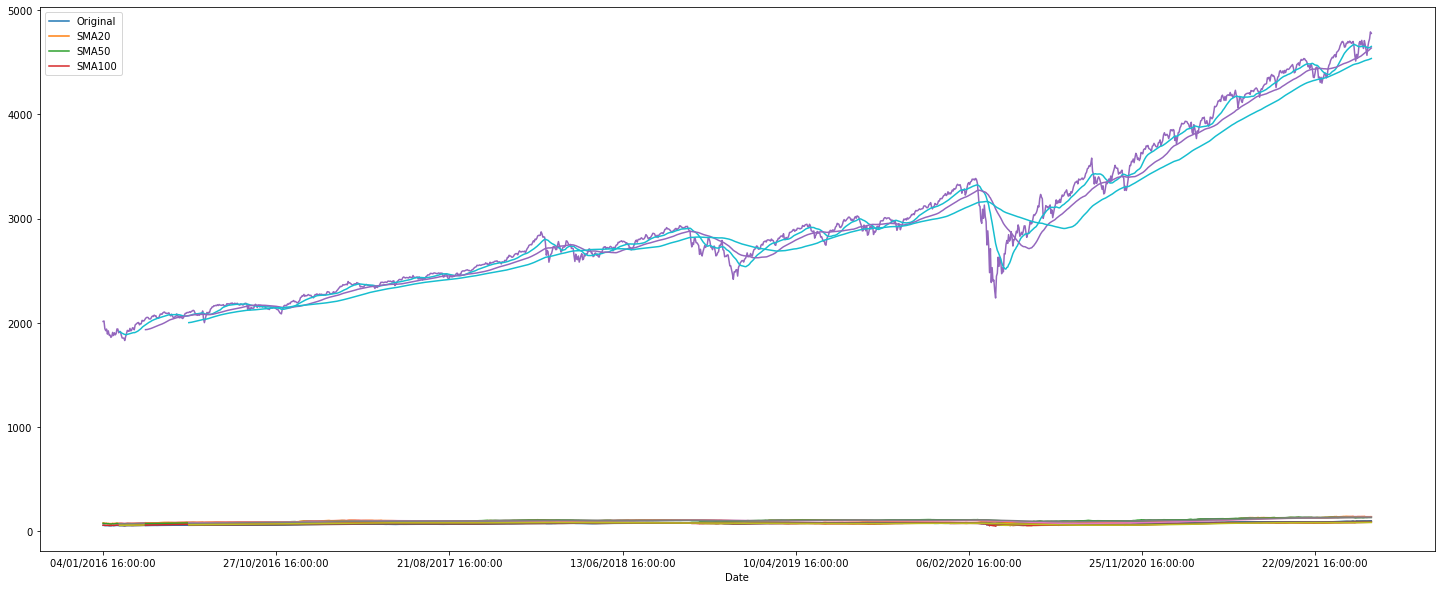

In [21]:
# Set figure of the daily closing prices of SHOP
ax = Stock_concat1.plot(figsize=(25,10))

# Overlay SMA20, SMA50, and SMA100 on the same figure
sma20.plot(ax=ax)
sma50.plot(ax=ax)
sma100.plot(ax=ax)

# Set the legend of the figure
ax.legend(["Original", "SMA20", "SMA50", "SMA100"]);

## Monte Carlo Simulation Forecasting the next 5 years performance of each stocks

### Data Preparation for MC Simulation

In [22]:
MCTd_data = pd.read_csv("Stock Data - TSE_TD.csv",infer_datetime_format=True, parse_dates=True, index_col="Date").reset_index()
MCBmo_data = pd.read_csv("Stock Data - TSE_BMO (1).csv",infer_datetime_format=True, parse_dates=True, index_col="Date").reset_index()
MCRY_data = pd.read_csv("Stock Data - TSE_RY (1).csv", infer_datetime_format=True, parse_dates=True, index_col="Date").reset_index()
MCBNS_data = pd.read_csv("Stock Data - TSE_BNS (2).csv", infer_datetime_format=True, parse_dates=True, index_col="Date").reset_index()
MCSP500_data = pd.read_csv("Stock Data - S&P 500 (1).csv",infer_datetime_format=True, parse_dates=True, index_col="Date").reset_index()

### MC Simulation for BMO

In [23]:
MCBmo_data.rename(columns={"Close": "close"}, inplace=True)

In [24]:
MCBmo_data

,Date,close
0,2016-04-01 16:00:00,76.66
1,2016-05-01 16:00:00,76.62
2,2016-06-01 16:00:00,74.92
3,2016-07-01 16:00:00,73.52
4,2016-08-01 16:00:00,73.52
...,...,...
1499,2021-12-22 16:00:00,135.35
1500,2021-12-23 16:00:00,135.58
1501,2021-12-24 13:00:00,135.87
1502,2021-12-29 16:00:00,136.94


In [25]:
MCBmo_data["Date"] = pd.to_datetime(MCBmo_data["Date"])
MCBmo_data

,Date,close
0,2016-04-01 16:00:00,76.66
1,2016-05-01 16:00:00,76.62
2,2016-06-01 16:00:00,74.92
3,2016-07-01 16:00:00,73.52
4,2016-08-01 16:00:00,73.52
...,...,...
1499,2021-12-22 16:00:00,135.35
1500,2021-12-23 16:00:00,135.58
1501,2021-12-24 13:00:00,135.87
1502,2021-12-29 16:00:00,136.94


In [26]:
MCBmo_data.set_index("Date", inplace=True)

In [27]:
MCBmo_data.index = MCBmo_data.index.date

In [28]:
MCBmo_data.index

Index([2016-04-01, 2016-05-01, 2016-06-01, 2016-07-01, 2016-08-01, 2016-11-01,
       2016-12-01, 2016-01-13, 2016-01-14, 2016-01-15,
       ...
       2021-12-15, 2021-12-16, 2021-12-17, 2021-12-20, 2021-12-21, 2021-12-22,
       2021-12-23, 2021-12-24, 2021-12-29, 2021-12-30],
      dtype='object', length=1504)

In [29]:
ticker_data_bmo = pd.concat([MCBmo_data], axis=1, keys=["BMO"])
ticker_data_bmo

,BMO
,close
2016-04-01,76.66
2016-05-01,76.62
2016-06-01,74.92
2016-07-01,73.52
2016-08-01,73.52
...,...
2021-12-22,135.35
2021-12-23,135.58
2021-12-24,135.87


In [30]:
MC_Bmo = MCSimulation(
    portfolio_data = ticker_data_bmo,
    num_simulation = 1000,
    num_trading_days = 252*5
)

MC_Bmo.portfolio_data.head().dropna()

BMO             
            close daily_return
2016-05-01  76.62    -0.000522
2016-06-01  74.92    -0.022187
2016-07-01  73.52    -0.018687
2016-08-01  73.52     0.000000

In [31]:
MC_Bmo.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/shahriarshochi/FinTechProject/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.014646,0.990344,0.992238,0.987172,1.025217,0.985225,0.999478,0.995232,0.981981,1.007086,...,1.011396,1.012954,0.992654,1.004546,1.008775,0.986388,1.007877,1.014177,1.013799,0.996021
2,1.015786,1.001217,0.991691,0.985187,1.020416,0.983617,1.006802,0.976268,0.987412,1.006510,...,1.004118,0.987866,0.967065,0.996019,1.036343,1.009829,0.990028,1.038924,1.030307,0.995521
3,1.018368,1.015844,0.995195,0.987503,1.028893,0.997473,1.025956,0.993662,0.980771,0.984283,...,1.013950,0.976965,0.973653,0.987279,1.034691,1.006545,0.981116,1.031692,1.011457,0.985966
4,0.999347,1.022024,0.990511,0.996791,1.013326,0.983556,1.001402,0.966047,0.955053,0.998363,...,1.002717,0.974914,0.967921,0.986799,1.036130,0.981161,0.965597,1.023340,1.027538,0.971507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.123379,1.540523,2.863599,1.052236,0.715029,1.783208,1.289460,1.797473,1.070808,0.523405,...,0.758019,1.550031,2.351119,1.029771,1.102837,0.694298,0.968643,2.635710,1.606307,1.183278
1257,2.075097,1.569417,2.860832,1.057240,0.703142,1.813730,1.283920,1.799264,1.071850,0.526338,...,0.746585,1.564804,2.385486,1.037409,1.106201,0.673107,0.973307,2.618305,1.585443,1.173437
1258,2.105874,1.565545,2.848980,1.055666,0.691240,1.775150,1.261087,1.761511,1.076395,0.537200,...,0.751530,1.541109,2.365109,1.018009,1.116062,0.691009,0.969251,2.589572,1.622258,1.156744
1259,2.146906,1.591957,2.865614,1.060244,0.674510,1.793309,1.228174,1.781286,1.048500,0.531915,...,0.753500,1.538638,2.379527,1.027461,1.111408,0.690962,0.970450,2.579333,1.612462,1.122132


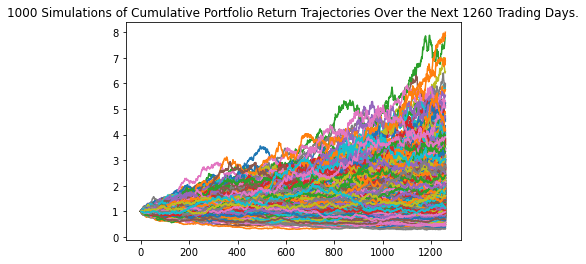

In [32]:
line_plot_bmo = MC_Bmo.plot_simulation()

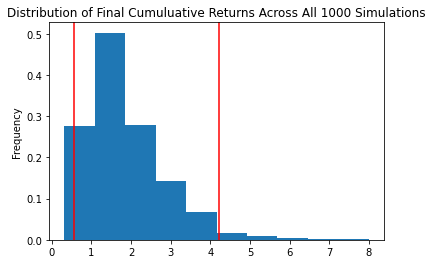

In [33]:
dist_plot_bmo = MC_Bmo.plot_distribution()

In [34]:
MC_sum_bmo = MC_Bmo.summarize_cumulative_return()
MC_sum_bmo

count           1000.000000
mean               1.851194
std                0.994820
min                0.318298
25%                1.158545
50%                1.645231
75%                2.314818
max                7.997238
95% CI Lower       0.570647
95% CI Upper       4.215525
Name: 1260, dtype: float64

In [92]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in BMO stocks
ci_lower = round(MC_sum_bmo[8]*10000,2)
ci_upper = round(MC_sum_bmo[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the BMO"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $10,000 in the BMO over the next 5 years will end within in the range of $5706.47 and $42155.25.


## MC Simulation for TD Bank

In [36]:
MCTd_data.rename(columns={"Close": "close"}, inplace=True)

In [37]:
MCTd_data

,Date,close
0,2016-04-01 16:00:00,53.72
1,2016-05-01 16:00:00,53.51
2,2016-06-01 16:00:00,52.18
3,2016-07-01 16:00:00,51.03
4,2016-08-01 16:00:00,51.05
...,...,...
1499,2021-12-22 16:00:00,95.41
1500,2021-12-23 16:00:00,96.21
1501,2021-12-24 13:00:00,96.30
1502,2021-12-29 16:00:00,97.51


In [38]:
MCTd_data["Date"] = pd.to_datetime(MCTd_data["Date"])
MCTd_data

,Date,close
0,2016-04-01 16:00:00,53.72
1,2016-05-01 16:00:00,53.51
2,2016-06-01 16:00:00,52.18
3,2016-07-01 16:00:00,51.03
4,2016-08-01 16:00:00,51.05
...,...,...
1499,2021-12-22 16:00:00,95.41
1500,2021-12-23 16:00:00,96.21
1501,2021-12-24 13:00:00,96.30
1502,2021-12-29 16:00:00,97.51


In [39]:
MCTd_data.set_index("Date", inplace=True)

In [40]:
MCTd_data.index = MCTd_data.index.date

In [41]:
MCTd_data.index

Index([2016-04-01, 2016-05-01, 2016-06-01, 2016-07-01, 2016-08-01, 2016-11-01,
       2016-12-01, 2016-01-13, 2016-01-14, 2016-01-15,
       ...
       2021-12-15, 2021-12-16, 2021-12-17, 2021-12-20, 2021-12-21, 2021-12-22,
       2021-12-23, 2021-12-24, 2021-12-29, 2021-12-30],
      dtype='object', length=1504)

In [42]:
ticker_data_td = pd.concat([MCTd_data], axis=1, keys=["TD"])
ticker_data_td

,TD
,close
2016-04-01,53.72
2016-05-01,53.51
2016-06-01,52.18
2016-07-01,51.03
2016-08-01,51.05
...,...
2021-12-22,95.41
2021-12-23,96.21
2021-12-24,96.30


In [43]:
MC_Td = MCSimulation(
    portfolio_data = ticker_data_td,
    num_simulation = 1000,
    num_trading_days = 252*5
)

MC_Td.portfolio_data.head().dropna()

TD             
            close daily_return
2016-05-01  53.51    -0.003909
2016-06-01  52.18    -0.024855
2016-07-01  51.03    -0.022039
2016-08-01  51.05     0.000392

In [44]:
MC_Td.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/shahriarshochi/FinTechProject/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.986736,0.994516,0.999182,0.982037,0.997395,1.000497,0.989550,0.997164,0.994357,0.988956,...,1.000175,1.022816,1.003826,1.001275,0.989387,0.995401,0.998017,1.000565,1.000494,1.010926
2,0.999022,1.001945,0.989197,1.009439,1.019521,0.992351,0.974040,0.990150,0.998427,1.003931,...,1.008711,1.029134,0.994393,1.019171,0.991342,1.042061,0.972591,0.987790,1.016283,1.012287
3,1.025355,1.031249,0.978471,0.995699,1.034130,1.002710,0.946417,0.993779,1.034543,1.007400,...,1.030979,1.018592,0.969952,1.018659,1.007961,1.032231,0.989005,1.005761,0.998224,1.011879
4,1.021449,1.027936,0.965453,0.980764,1.009608,1.015412,0.970980,0.993010,1.017764,1.003680,...,1.010130,1.040553,0.951025,1.004651,1.005762,1.042308,1.003424,0.989537,0.993731,1.020374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.886958,2.097489,0.893823,1.101159,1.126531,1.817045,2.568989,2.514711,1.939882,2.008675,...,1.712283,2.057517,1.336830,2.123316,1.906864,1.776798,3.055051,1.130320,1.189648,1.240361
1257,0.885517,2.064243,0.892183,1.117849,1.151145,1.832020,2.525793,2.493738,1.952450,2.045409,...,1.711759,2.014235,1.354981,2.119145,1.935004,1.753554,3.057130,1.141516,1.169301,1.277506
1258,0.892531,2.018413,0.880264,1.127180,1.163551,1.816069,2.509962,2.494732,1.940240,2.067392,...,1.717085,2.005080,1.357904,2.187714,1.976949,1.750603,3.102016,1.138587,1.184220,1.283367
1259,0.877667,2.046841,0.875138,1.110865,1.161147,1.794716,2.470727,2.505707,1.933494,2.060109,...,1.728480,1.963015,1.351972,2.207995,1.983825,1.751898,3.045942,1.125365,1.187273,1.296132


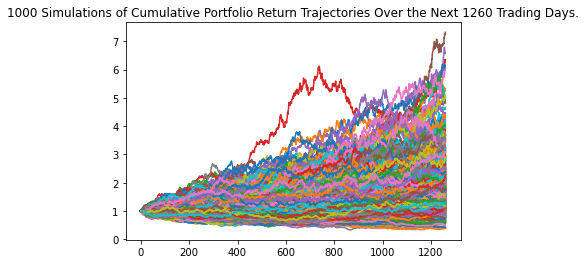

In [45]:
line_plot_td = MC_Td.plot_simulation()

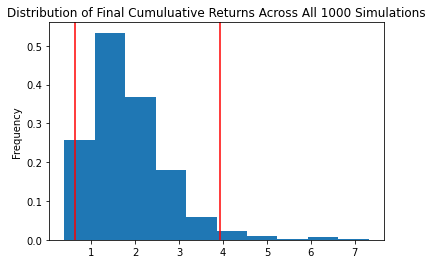

In [46]:
dist_plot_td = MC_Td.plot_distribution()

In [47]:
MC_sum_Td = MC_Td.summarize_cumulative_return()
MC_sum_Td

count           1000.000000
mean               1.827084
std                0.891702
min                0.386734
25%                1.190182
50%                1.665872
75%                2.269720
max                7.319063
95% CI Lower       0.636507
95% CI Upper       3.932279
Name: 1260, dtype: float64

In [91]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in TD stocks
ci_lower = round(MC_sum_Td[8]*10000,2)
ci_upper = round(MC_sum_Td[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the TD"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $10,000 in the TD over the next 5 years will end within in the range of $6365.07 and $39322.79.


### MC Simulation for Royal Bank of Canada

In [49]:
MCRY_data.rename(columns={"Close": "close"}, inplace=True)

In [50]:
MCRY_data

,Date,close
0,2016-04-01 16:00:00,73.04
1,2016-05-01 16:00:00,72.82
2,2016-07-01 16:00:00,70.25
3,2016-11-01 16:00:00,70.41
4,2016-12-01 16:00:00,70.92
...,...,...
1497,2021-12-22 16:00:00,132.59
1498,2021-12-23 16:00:00,133.64
1499,2021-12-24 13:00:00,133.99
1500,2021-12-29 16:00:00,134.79


In [51]:
MCRY_data["Date"] = pd.to_datetime(MCRY_data["Date"])
MCRY_data

,Date,close
0,2016-04-01 16:00:00,73.04
1,2016-05-01 16:00:00,72.82
2,2016-07-01 16:00:00,70.25
3,2016-11-01 16:00:00,70.41
4,2016-12-01 16:00:00,70.92
...,...,...
1497,2021-12-22 16:00:00,132.59
1498,2021-12-23 16:00:00,133.64
1499,2021-12-24 13:00:00,133.99
1500,2021-12-29 16:00:00,134.79


In [52]:
MCRY_data.set_index("Date", inplace=True)

In [53]:
MCRY_data.index = MCRY_data.index.date

In [54]:
MCRY_data.index

Index([2016-04-01, 2016-05-01, 2016-07-01, 2016-11-01, 2016-12-01, 2016-01-13,
       2016-01-14, 2016-01-15, 2016-01-18, 2016-01-19,
       ...
       2021-12-15, 2021-12-16, 2021-12-17, 2021-12-20, 2021-12-21, 2021-12-22,
       2021-12-23, 2021-12-24, 2021-12-29, 2021-12-30],
      dtype='object', length=1502)

In [55]:
ticker_data_ry = pd.concat([MCRY_data], axis=1, keys=["RY"])
ticker_data_ry

,RY
,close
2016-04-01,73.04
2016-05-01,72.82
2016-07-01,70.25
2016-11-01,70.41
2016-12-01,70.92
...,...
2021-12-22,132.59
2021-12-23,133.64
2021-12-24,133.99


In [56]:
MC_RY = MCSimulation(
    portfolio_data = ticker_data_ry,
    num_simulation = 1000,
    num_trading_days = 252*5
)

MC_RY.portfolio_data.head().dropna()

RY             
            close daily_return
2016-05-01  72.82    -0.003012
2016-07-01  70.25    -0.035293
2016-11-01  70.41     0.002278
2016-12-01  70.92     0.007243

In [57]:
MC_RY.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/shahriarshochi/FinTechProject/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998078,1.000266,1.003364,1.005282,1.013608,1.002989,0.992960,0.994995,0.979343,1.001507,...,0.971989,0.992820,0.988937,1.013385,0.992526,1.006002,0.989365,0.983698,1.019013,1.000665
2,0.988417,1.018709,1.009489,1.025923,1.014899,1.016478,1.000848,1.011120,0.984765,0.988829,...,0.968123,0.984567,0.997562,1.019389,0.995460,1.015656,0.971132,0.998721,1.005753,1.000719
3,0.982175,1.015624,1.008816,1.042997,1.013116,1.022701,0.975663,0.992179,0.980191,0.984617,...,0.983442,0.971295,1.002522,1.017537,0.986270,1.020476,0.947601,0.996823,1.004425,1.006197
4,0.980575,1.017220,1.026165,1.059334,1.004225,1.033795,0.959161,0.994260,0.999106,0.988866,...,0.949446,0.978327,1.023783,1.014496,0.967646,1.006598,0.937670,0.972240,0.999925,1.000967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.352240,2.411232,1.379914,1.703511,1.836518,1.731591,2.092932,1.403622,1.247088,0.840056,...,1.386221,2.150132,1.456340,2.073412,1.096433,2.355129,1.804155,2.881444,1.159810,1.640982
1257,1.372929,2.423004,1.392000,1.695965,1.862010,1.732601,2.095345,1.416098,1.248840,0.843982,...,1.351995,2.163966,1.437304,2.089380,1.105473,2.344626,1.780367,2.893006,1.163298,1.647757
1258,1.371794,2.383664,1.398835,1.691457,1.875040,1.725805,2.117357,1.408973,1.278510,0.849331,...,1.345276,2.161283,1.476056,2.115823,1.091459,2.306603,1.780746,2.901931,1.177032,1.633396
1259,1.379129,2.390660,1.407137,1.707897,1.855358,1.716302,2.084975,1.410221,1.286337,0.838139,...,1.330674,2.129108,1.473048,2.105220,1.085032,2.273111,1.743903,2.890360,1.160083,1.652792


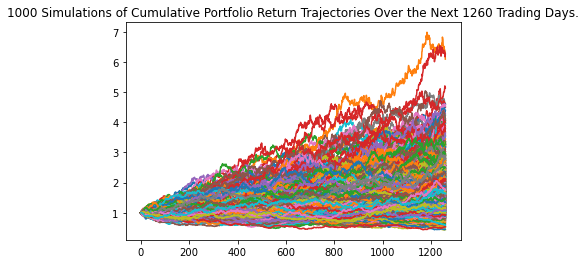

In [58]:
line_plot_ry = MC_RY.plot_simulation()

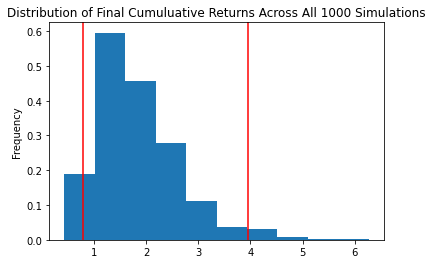

In [59]:
dist_plot_ry = MC_RY.plot_distribution()

In [60]:
MC_sum_ry = MC_RY.summarize_cumulative_return()
MC_sum_ry

count           1000.000000
mean               1.840589
std                0.788137
min                0.436537
25%                1.291213
50%                1.686541
75%                2.236420
max                6.263461
95% CI Lower       0.786103
95% CI Upper       3.954968
Name: 1260, dtype: float64

In [90]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in RY stocks
ci_lower = round(MC_sum_ry[8]*10000,2)
ci_upper = round(MC_sum_ry[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the RBC"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $10,000 in the RBC over the next 5 years will end within in the range of $7861.03 and $39549.68.


### MC Simulation for Bank of Nova Scotia

In [62]:
MCBNS_data.rename(columns={"Close": "close"}, inplace=True)

In [63]:
MCBNS_data

,Date,close
0,2016-04-01 16:00:00,55.54
1,2016-05-01 16:00:00,56.13
2,2016-06-01 16:00:00,55.16
3,2016-07-01 16:00:00,54.31
4,2016-08-01 16:00:00,54.56
...,...,...
1499,2021-12-22 16:00:00,88.67
1500,2021-12-23 16:00:00,89.31
1501,2021-12-24 13:00:00,89.76
1502,2021-12-29 16:00:00,91.22


In [64]:
MCBNS_data["Date"] = pd.to_datetime(MCBNS_data["Date"])
MCBNS_data

,Date,close
0,2016-04-01 16:00:00,55.54
1,2016-05-01 16:00:00,56.13
2,2016-06-01 16:00:00,55.16
3,2016-07-01 16:00:00,54.31
4,2016-08-01 16:00:00,54.56
...,...,...
1499,2021-12-22 16:00:00,88.67
1500,2021-12-23 16:00:00,89.31
1501,2021-12-24 13:00:00,89.76
1502,2021-12-29 16:00:00,91.22


In [65]:
MCBNS_data.set_index("Date", inplace=True)

In [66]:
MCBNS_data.index = MCBNS_data.index.date

In [67]:
MCBNS_data.index

Index([2016-04-01, 2016-05-01, 2016-06-01, 2016-07-01, 2016-08-01, 2016-11-01,
       2016-12-01, 2016-01-13, 2016-01-14, 2016-01-15,
       ...
       2021-12-15, 2021-12-16, 2021-12-17, 2021-12-20, 2021-12-21, 2021-12-22,
       2021-12-23, 2021-12-24, 2021-12-29, 2021-12-30],
      dtype='object', length=1504)

In [68]:
ticker_data_bns = pd.concat([MCBNS_data], axis=1, keys=["BNS"])
ticker_data_bns

,BNS
,close
2016-04-01,55.54
2016-05-01,56.13
2016-06-01,55.16
2016-07-01,54.31
2016-08-01,54.56
...,...
2021-12-22,88.67
2021-12-23,89.31
2021-12-24,89.76


In [69]:
MC_BNS = MCSimulation(
    portfolio_data = ticker_data_bns,
    num_simulation = 1000,
    num_trading_days = 252*5
)

MC_BNS.portfolio_data.head().dropna()

BNS             
            close daily_return
2016-05-01  56.13     0.010623
2016-06-01  55.16    -0.017281
2016-07-01  54.31    -0.015410
2016-08-01  54.56     0.004603

In [70]:
MC_BNS.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/shahriarshochi/FinTechProject/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.972115,1.004997,1.009460,1.017493,0.996133,0.993375,0.998957,0.982273,1.009850,0.997932,...,0.993288,1.004793,1.008229,0.994878,0.996115,0.986352,1.014755,0.983588,1.013456,0.996054
2,0.993120,1.018414,1.026447,1.019457,0.999179,1.010823,0.978705,0.978222,0.993892,0.991177,...,1.006744,1.027172,1.002706,1.008848,0.962592,0.996666,1.026566,0.989257,1.006535,0.990223
3,0.981406,1.000933,1.034379,1.034171,0.999064,1.009484,0.973090,0.988997,0.984678,1.001460,...,1.042501,1.025970,0.999193,1.001137,0.952619,1.026987,1.049752,0.985034,1.019695,0.976707
4,0.975595,1.018538,1.022111,1.017888,0.998706,1.006570,0.997472,0.994002,0.984161,0.964511,...,1.030171,1.032770,1.005068,0.984471,0.953261,1.042263,1.038736,0.989287,1.030922,0.984836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.314496,1.560644,0.617788,1.127249,1.177445,1.256320,1.286466,2.904298,1.058152,1.538787,...,1.315635,2.131580,1.372498,2.008366,1.601492,1.192385,2.142945,1.021710,1.107455,1.076667
1257,1.329006,1.572329,0.613671,1.126448,1.177531,1.228406,1.305663,2.886467,1.065647,1.541511,...,1.314534,2.124774,1.379351,2.020356,1.560581,1.172260,2.121177,1.048140,1.121120,1.060247
1258,1.353147,1.617797,0.626402,1.122078,1.177324,1.226616,1.306728,2.876045,1.073150,1.505299,...,1.333601,2.144826,1.382821,2.065123,1.558573,1.169057,2.099442,1.079743,1.150790,1.064650
1259,1.351304,1.614599,0.628360,1.091469,1.194535,1.225038,1.305990,2.837089,1.098570,1.514348,...,1.298107,2.131269,1.385566,2.070999,1.563080,1.179573,2.061349,1.075485,1.177537,1.074220


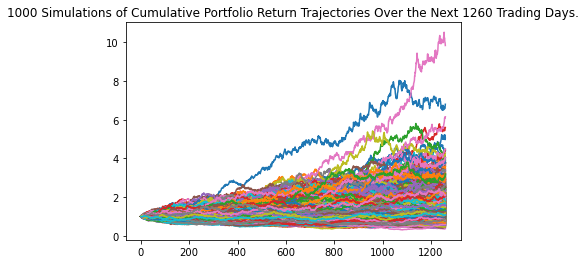

In [71]:
line_plot_bns = MC_BNS.plot_simulation()

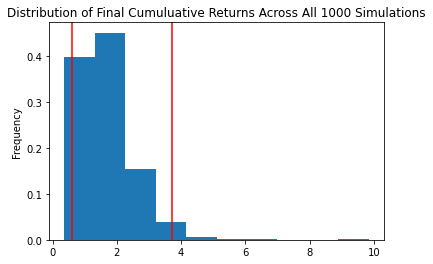

In [72]:
dist_plot_bns = MC_BNS.plot_distribution()

In [73]:
MC_sum_bns = MC_BNS.summarize_cumulative_return()
MC_sum_bns

count           1000.000000
mean               1.697785
std                0.838504
min                0.367767
25%                1.124141
50%                1.534557
75%                2.091355
max                9.839259
95% CI Lower       0.602920
95% CI Upper       3.733752
Name: 1260, dtype: float64

In [89]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in BNS stocks
ci_lower = round(MC_sum_bns[8]*10000,2)
ci_upper = round(MC_sum_bns[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the Scotiabank"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $10,000 in the Scotiabank over the next 5 years will end within in the range of $6029.2 and $37337.52.


### MC Simulation for S&P 500

In [75]:
MCSP500_data.rename(columns={"Close": "close"}, inplace=True)

In [76]:
MCSP500_data

,Date,close
0,2016-04-01 16:00:00,2012.66
1,2016-05-01 16:00:00,2016.71
2,2016-06-01 16:00:00,1990.26
3,2016-07-01 16:00:00,1943.09
4,2016-08-01 16:00:00,1922.03
...,...,...
1505,2021-12-23 16:00:00,4725.79
1506,2021-12-27 16:00:00,4791.19
1507,2021-12-28 16:00:00,4786.35
1508,2021-12-29 16:00:00,4793.06


In [77]:
MCSP500_data["Date"] = pd.to_datetime(MCSP500_data["Date"])
MCSP500_data

,Date,close
0,2016-04-01 16:00:00,2012.66
1,2016-05-01 16:00:00,2016.71
2,2016-06-01 16:00:00,1990.26
3,2016-07-01 16:00:00,1943.09
4,2016-08-01 16:00:00,1922.03
...,...,...
1505,2021-12-23 16:00:00,4725.79
1506,2021-12-27 16:00:00,4791.19
1507,2021-12-28 16:00:00,4786.35
1508,2021-12-29 16:00:00,4793.06


In [78]:
MCSP500_data.set_index("Date", inplace=True)

In [79]:
MCSP500_data.index = MCSP500_data.index.date

In [80]:
MCSP500_data

,close
2016-04-01,2012.66
2016-05-01,2016.71
2016-06-01,1990.26
2016-07-01,1943.09
2016-08-01,1922.03
...,...
2021-12-23,4725.79
2021-12-27,4791.19
2021-12-28,4786.35
2021-12-29,4793.06


In [81]:
ticker_data_sp500 = pd.concat([MCSP500_data], axis=1, keys=["SP500"])
ticker_data_sp500

,SP500
,close
2016-04-01,2012.66
2016-05-01,2016.71
2016-06-01,1990.26
2016-07-01,1943.09
2016-08-01,1922.03
...,...
2021-12-23,4725.79
2021-12-27,4791.19
2021-12-28,4786.35


In [82]:
MC_SP500 = MCSimulation(
    portfolio_data = ticker_data_sp500,
    num_simulation = 1000,
    num_trading_days = 252*5
)

MC_SP500.portfolio_data.head().dropna()

SP500             
              close daily_return
2016-05-01  2016.71     0.002012
2016-06-01  1990.26    -0.013115
2016-07-01  1943.09    -0.023700
2016-08-01  1922.03    -0.010838

In [83]:
MC_SP500.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/shahriarshochi/FinTechProject/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995972,1.007222,1.015435,0.975466,0.986276,1.009627,1.010003,1.019864,1.013561,0.997200,...,1.031772,1.014247,1.007883,0.987891,0.990239,0.999348,0.993205,1.000622,0.980693,1.008411
2,0.995002,0.999905,1.018276,0.986621,0.993167,1.011668,1.019654,1.039752,1.019346,0.994240,...,1.021991,1.016262,1.011842,0.992107,1.007591,1.003528,0.970745,0.994022,1.000750,0.997416
3,1.002085,0.990782,1.027879,0.998137,0.993291,0.983638,1.043772,1.051103,1.023476,0.988499,...,1.021059,1.031076,1.008528,0.985391,0.995808,1.021808,0.977454,1.013115,1.000616,0.993302
4,0.995357,0.994573,1.025699,1.013318,0.997648,0.978681,1.046369,1.056134,1.006693,0.986923,...,1.014635,1.039722,0.998646,1.000504,0.995118,1.014166,0.982535,0.981473,1.013377,0.989523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.754937,2.319323,2.316410,2.631259,4.848580,1.606696,4.101767,3.184301,1.872577,1.214209,...,2.611886,1.772155,2.933777,1.921671,1.830559,1.658616,1.254752,1.487849,2.393495,3.665925
1257,1.769225,2.335938,2.349908,2.634551,4.941439,1.599639,4.036720,3.169252,1.841897,1.228173,...,2.640714,1.752317,2.913494,1.904182,1.838549,1.675912,1.270011,1.489279,2.366690,3.683306
1258,1.787210,2.323466,2.356070,2.644107,5.025731,1.606950,4.021755,3.136058,1.881538,1.257720,...,2.604001,1.733097,2.878760,1.893227,1.867218,1.672990,1.304865,1.516007,2.383311,3.704053
1259,1.787881,2.319420,2.357399,2.670773,5.054719,1.623808,4.063124,3.151660,1.878227,1.269031,...,2.611764,1.714020,2.892385,1.932254,1.853702,1.649029,1.291880,1.527072,2.373901,3.666215


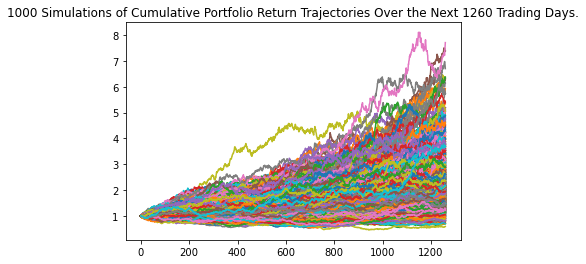

In [84]:
line_plot_sp500 = MC_SP500.plot_simulation()

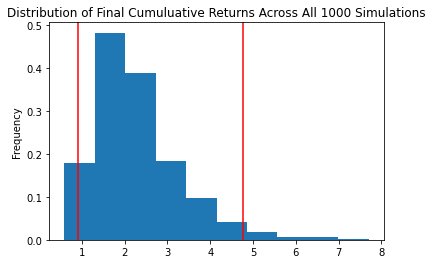

In [85]:
dist_plot_sp500 = MC_SP500.plot_distribution()

In [86]:
MC_sum_sp500 = MC_SP500.summarize_cumulative_return()
MC_sum_sp500

count           1000.000000
mean               2.275356
std                1.005924
min                0.586845
25%                1.568607
50%                2.079571
75%                2.737487
max                7.706085
95% CI Lower       0.912004
95% CI Upper       4.774328
Name: 1260, dtype: float64

In [88]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in SNP500 stocks
ci_lower = round(MC_sum_sp500[8]*10000,2)
ci_upper = round(MC_sum_sp500[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the S&P 500"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $10,000 in the S&P 500 over the next 5 years will end within in the range of $9120.04 and $47743.28.
